In [1]:
import matplotlib.pyplot as plt
import mlrose_hiive as mlrose
import numpy as np
import pandas as pd
import pickle as pk
import sklearn
import time
from pandas.plotting import scatter_matrix
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, r2_score, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV, learning_curve, train_test_split, validation_curve, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils import resample

*** 
## DATA IMPORT & CHECK
***

In [2]:
# sep=';' since each value is separated using semi-colon instead of comma. 
df = pd.read_csv('../data/winequality-white.csv', sep=';')

In [3]:
# confirm number of rows and columns as indicated by UCI
df.shape

(4898, 12)

In [4]:
# check if any value are null
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [5]:
# get statistical summary of the dataset per each column
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


3      20
4     163
5    1457
6    2198
7     880
8     175
9       5
Name: quality, dtype: int64


Text(0, 0.5, 'Frequency')

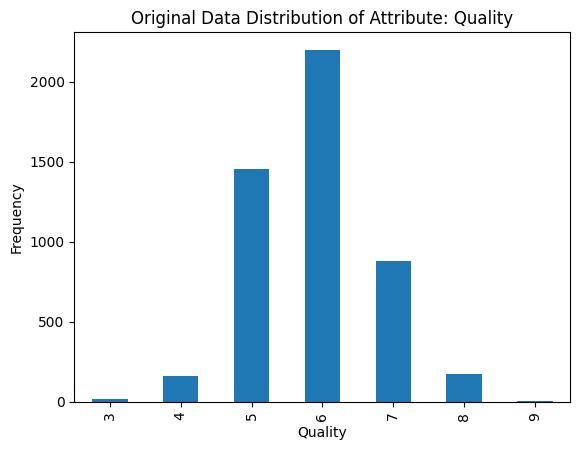

In [6]:
# check original data distribution of source attribute before converting to binary classification
print(df['quality'].value_counts().sort_index())
ax = df['quality'].value_counts().sort_index().plot(title='Original Data Distribution of Attribute: Quality', kind='bar')
ax.set_xlabel('Quality')
ax.set_ylabel('Frequency')

1    3258
0    1640
Name: recommend, dtype: int64


Text(0, 0.5, 'Frequency')

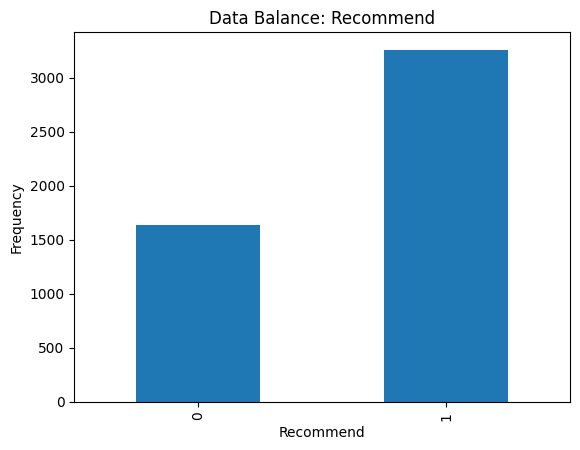

In [7]:
# convert multi-class classification problem into binary by consolidating rows based on existing quality column
# if quality is 6 or above, recommend. otherwise, don't recommend
df['recommend'] = [0 if val<6 else 1 for val in df['quality']]

# check if conversion successful
print(df['recommend'].value_counts())
ax = df['recommend'].value_counts().sort_index().plot(title='Data Balance: Recommend', kind='bar')
ax.set_xlabel('Recommend')
ax.set_ylabel('Frequency')

In [8]:
# drop legacy column
df = df.drop(['quality'], axis=1)
# verify column no longer exists
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  recommend             4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


*** 
## DATA PREPARATION
***

In [9]:
# X includes input/features
X = np.asarray(df.iloc[:,:-1])
# y includes target class/label
y = np.asarray(df['recommend'])

In [10]:
# split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37)

In [11]:
# standardize dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
# X_test = scaler.fit_transform(X_test)

In [12]:
# confirm data after train test split
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

X_train: (3918, 11)
X_test: (980, 11)
y_train: (3918,)
y_test: (980,)


*** 
## Custom Functions
***

In [13]:
# plots learning curve showing performance vs. training size
def get_learning_curve_size(clf, clf_name, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=37), scoring="accuracy", train_sizes=np.linspace(start=0.1, stop=1.0, num=5)):
    """
    uses sklearn's learning_curve() to train clf using various sizes of training data
    
    Parameters
    ----------
    train_sizes : array-like of shape (n_ticks,) - see next line
        By default, it's [0.1   0.325 0.55  0.775 1.]
        Think of each float as percentage of total training data.
        So starts at 10%, increases by 22.5% every trial until reaching 100%
    
    cv : int, cross-validation generator/iterable
        - if int, specifies number of folds
    
    """
    sizes, training_scores, valid_scores = learning_curve(clf, X, y, cv=cv, scoring=scoring, train_sizes=train_sizes)

    # average training & validation scores
    avg_training_score = np.mean(training_scores, axis=1)
    avg_valid_scores = np.mean(valid_scores, axis=1)

    # plot and show
    plt.plot(sizes, avg_training_score, color="blue", label="Training Performance")
    plt.plot(sizes, avg_valid_scores, color="red", label="Validation Performance")
    plt.title("Training Size Learning Curve for {}".format(clf_name))
    plt.xlabel("Training Size"), plt.ylabel("Accuracy"), plt.legend(loc="best")
    plt.tight_layout()
    plt.grid()
    plt.show()
    

# plots loss curve showing loss vs. iteration
def get_loss_curve(clf, clf_name):
    """
    uses MLPClassifier's loss_curve_ attribute to plot accuracy over iterations
    purpose of this function is to plot performance over time and therefore iterations.
   
    """
    # plot and show
    loss_curve = pd.DataFrame(clf.loss_curve_)
    loss_curve = loss_curve.set_axis(['Neural Network Performance'], axis=1, inplace=False)
    loss_curve.plot()
    plt.title("Iterative Loss Curve for {}".format(clf_name))
    plt.xlabel("Iterations"), plt.ylabel("Loss"), plt.legend(loc="best")
    plt.tight_layout()
    plt.grid()
    plt.show()    

*** 
## Neural Network Weight Optimization
***

***
### 1. Random Hill Climbing
*** 

In [25]:
'''
Source: https://github.com/hiive/mlrose/blob/master/mlrose_hiive/neural/neural_network.py

'''

rhc_mlp_clf = mlrose.NeuralNetwork(hidden_nodes=[25],
                                  activation='relu',
                                  algorithm='random_hill_climb',
                                  max_iters=100,
                                  bias=True,
                                  is_classifier=True,
                                  learning_rate=.1,
                                  early_stopping=True,
                                  restarts=0,
                                  max_attempts=10,
                                  random_state=37,
                                  curve=False)

# start timer for training
start = time.time()
# train classifier
rhc_mlp_clf.fit(X_train, y_train)
# end timer for training
end = time.time()
# print total time for training
print(f"Total Training Time: {round(end-start, 5)}s")

# start timer for testing
start = time.time()
# make prediction
y_pred = rhc_mlp_clf.predict(X_test)
# end timer for testing
end = time.time()
# print total time for testing
print(f"Total Testing Time: {round(end-start, 5)}s")

# evaluate model performance on test data
print("Accuracy using test set:", accuracy_score(y_test, y_pred))
# evaluate model performance using confusion_matrix
print(confusion_matrix(y_test, y_pred))
# evaluate model performance using classification_report
print(classification_report(y_test, y_pred))

# Total Training Time: 0.27603s
# Total Testing Time: 0.00097s
# Accuracy using test set: 0.6806122448979591
# [[  0 313]
#  [  0 667]]
#               precision    recall  f1-score   support

#            0       0.00      0.00      0.00       313
#            1       0.68      1.00      0.81       667

#     accuracy                           0.68       980
#    macro avg       0.34      0.50      0.40       980
# weighted avg       0.46      0.68      0.55       980


Total Training Time: 0.33297s
Total Testing Time: 0.001s
Accuracy using test set: 0.6806122448979591
[[  0 313]
 [  0 667]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       313
           1       0.68      1.00      0.81       667

    accuracy                           0.68       980
   macro avg       0.34      0.50      0.40       980
weighted avg       0.46      0.68      0.55       980



In [ ]:
'''
Source: https://github.com/hiive/mlrose/blob/master/mlrose_hiive/neural/neural_network.py

'''

rhc_mlp_clf = mlrose.NeuralNetwork(hidden_nodes=[25],
                                  activation='relu',
                                  algorithm='random_hill_climb',
                                  max_iters=100,
                                  bias=True,
                                  is_classifier=True,
                                  learning_rate=.1,
                                  early_stopping=True,
                                  restarts=10,
                                  max_attempts=10,
                                  random_state=37,
                                  curve=False)

# start timer for training
start = time.time()
# train classifier
rhc_mlp_clf.fit(X_train, y_train)
# end timer for training
end = time.time()
# print total time for training
print(f"Total Training Time: {round(end-start, 5)}s")

# start timer for testing
start = time.time()
# make prediction
y_pred = rhc_mlp_clf.predict(X_test)
# end timer for testing
end = time.time()
# print total time for testing
print(f"Total Testing Time: {round(end-start, 5)}s")

# evaluate model performance on test data
print("Accuracy using test set:", accuracy_score(y_test, y_pred))
# evaluate model performance using confusion_matrix
print(confusion_matrix(y_test, y_pred))
# evaluate model performance using classification_report
print(classification_report(y_test, y_pred))

# Total Training Time: 2.868s
# Total Testing Time: 0.001s
# Accuracy using test set: 0.6806122448979591
# [[  0 313]
#  [  0 667]]
#               precision    recall  f1-score   support

#            0       0.00      0.00      0.00       313
#            1       0.68      1.00      0.81       667

#     accuracy                           0.68       980
#    macro avg       0.34      0.50      0.40       980
# weighted avg       0.46      0.68      0.55       980

In [ ]:
'''
Source: https://github.com/hiive/mlrose/blob/master/mlrose_hiive/neural/neural_network.py

'''

rhc_mlp_clf = mlrose.NeuralNetwork(hidden_nodes=[25],
                                  activation='relu',
                                  algorithm='random_hill_climb',
                                  max_iters=500,
                                  bias=True,
                                  is_classifier=True,
                                  learning_rate=.1,
                                  early_stopping=True,
                                  restarts=1,
                                  max_attempts=10,
                                  random_state=37,
                                  curve=False)

# start timer for training
start = time.time()
# train classifier
rhc_mlp_clf.fit(X_train, y_train)
# end timer for training
end = time.time()
# print total time for training
print(f"Total Training Time: {round(end-start, 5)}s")

# start timer for testing
start = time.time()
# make prediction
y_pred = rhc_mlp_clf.predict(X_test)
# end timer for testing
end = time.time()
# print total time for testing
print(f"Total Testing Time: {round(end-start, 5)}s")

# evaluate model performance on test data
print("Accuracy using test set:", accuracy_score(y_test, y_pred))
# evaluate model performance using confusion_matrix
print(confusion_matrix(y_test, y_pred))
# evaluate model performance using classification_report
print(classification_report(y_test, y_pred))

# Total Training Time: 2.489s
# Total Testing Time: 0.0s
# Accuracy using test set: 0.3193877551020408
# [[311   2]
#  [665   2]]
#               precision    recall  f1-score   support

#            0       0.32      0.99      0.48       313
#            1       0.50      0.00      0.01       667

#     accuracy                           0.32       980
#    macro avg       0.41      0.50      0.24       980
# weighted avg       0.44      0.32      0.16       980

In [ ]:
'''
Source: https://github.com/hiive/mlrose/blob/master/mlrose_hiive/neural/neural_network.py

'''

rhc_mlp_clf = mlrose.NeuralNetwork(hidden_nodes=[25],
                                  activation='relu',
                                  algorithm='random_hill_climb',
                                  max_iters=100,
                                  bias=True,
                                  is_classifier=True,
                                  learning_rate=1,
                                  early_stopping=True,
                                  restarts=1,
                                  max_attempts=10,
                                  random_state=37,
                                  curve=False)

# start timer for training
start = time.time()
# train classifier
rhc_mlp_clf.fit(X_train, y_train)
# end timer for training
end = time.time()
# print total time for training
print(f"Total Training Time: {round(end-start, 5)}s")

# start timer for testing
start = time.time()
# make prediction
y_pred = rhc_mlp_clf.predict(X_test)
# end timer for testing
end = time.time()
# print total time for testing
print(f"Total Testing Time: {round(end-start, 5)}s")

# evaluate model performance on test data
print("Accuracy using test set:", accuracy_score(y_test, y_pred))
# evaluate model performance using confusion_matrix
print(confusion_matrix(y_test, y_pred))
# evaluate model performance using classification_report
print(classification_report(y_test, y_pred))

# Total Training Time: 0.37s
# Total Testing Time: 0.001s
# Accuracy using test set: 0.6459183673469387
# [[ 22 291]
#  [ 56 611]]
#               precision    recall  f1-score   support

#            0       0.28      0.07      0.11       313
#            1       0.68      0.92      0.78       667

#     accuracy                           0.65       980
#    macro avg       0.48      0.49      0.45       980
# weighted avg       0.55      0.65      0.57       980

In [ ]:
'''
Source: https://github.com/hiive/mlrose/blob/master/mlrose_hiive/neural/neural_network.py

'''

rhc_mlp_clf = mlrose.NeuralNetwork(hidden_nodes=[25],
                                  activation='relu',
                                  algorithm='random_hill_climb',
                                  max_iters=1000,
                                  bias=True,
                                  is_classifier=True,
                                  learning_rate=.1,
                                  early_stopping=True,
                                  restarts=1,
                                  max_attempts=10,
                                  random_state=37,
                                  curve=False)

# start timer for training
start = time.time()
# train classifier
rhc_mlp_clf.fit(X_train, y_train)
# end timer for training
end = time.time()
# print total time for training
print(f"Total Training Time: {round(end-start, 5)}s")

# start timer for testing
start = time.time()
# make prediction
y_pred = rhc_mlp_clf.predict(X_test)
# end timer for testing
end = time.time()
# print total time for testing
print(f"Total Testing Time: {round(end-start, 5)}s")

# evaluate model performance on test data
print("Accuracy using test set:", accuracy_score(y_test, y_pred))
# evaluate model performance using confusion_matrix
print(confusion_matrix(y_test, y_pred))
# evaluate model performance using classification_report
print(classification_report(y_test, y_pred))

# Total Training Time: 3.434s
# Total Testing Time: 0.001s
# Accuracy using test set: 0.3173469387755102
# [[309   4]
#  [665   2]]
#               precision    recall  f1-score   support

#            0       0.32      0.99      0.48       313
#            1       0.33      0.00      0.01       667

#     accuracy                           0.32       980
#    macro avg       0.33      0.50      0.24       980
# weighted avg       0.33      0.32      0.16       980

In [ ]:
'''
Source: https://github.com/hiive/mlrose/blob/master/mlrose_hiive/neural/neural_network.py

'''

rhc_mlp_clf = mlrose.NeuralNetwork(hidden_nodes=[25],
                                  activation='relu',
                                  algorithm='random_hill_climb',
                                  max_iters=100,
                                  bias=True,
                                  is_classifier=True,
                                  learning_rate=.1,
                                  early_stopping=True,
                                  restarts=1,
                                  max_attempts=100,
                                  random_state=37,
                                  curve=False)

# start timer for training
start = time.time()
# train classifier
rhc_mlp_clf.fit(X_train, y_train)
# end timer for training
end = time.time()
# print total time for training
print(f"Total Training Time: {round(end-start, 5)}s")

# start timer for testing
start = time.time()
# make prediction
y_pred = rhc_mlp_clf.predict(X_test)
# end timer for testing
end = time.time()
# print total time for testing
print(f"Total Testing Time: {round(end-start, 5)}s")

# evaluate model performance on test data
print("Accuracy using test set:", accuracy_score(y_test, y_pred))
# evaluate model performance using confusion_matrix
print(confusion_matrix(y_test, y_pred))
# evaluate model performance using classification_report
print(classification_report(y_test, y_pred))

# Total Training Time: 0.524s
# Total Testing Time: 0.0s
# Accuracy using test set: 0.6806122448979591
# [[  0 313]
#  [  0 667]]
#               precision    recall  f1-score   support

#            0       0.00      0.00      0.00       313
#            1       0.68      1.00      0.81       667

#     accuracy                           0.68       980
#    macro avg       0.34      0.50      0.40       980
# weighted avg       0.46      0.68      0.55       980


In [ ]:
'''
Source: https://github.com/hiive/mlrose/blob/master/mlrose_hiive/neural/neural_network.py

'''

rhc_mlp_clf = mlrose.NeuralNetwork(hidden_nodes=[25],
                                  activation='relu',
                                  algorithm='random_hill_climb',
                                  max_iters=100,
                                  bias=True,
                                  is_classifier=True,
                                  learning_rate=.1,
                                  early_stopping=True,
                                  restarts=100,
                                  max_attempts=100,
                                  random_state=37,
                                  curve=False)

# start timer for training
start = time.time()
# train classifier
rhc_mlp_clf.fit(X_train, y_train)
# end timer for training
end = time.time()
# print total time for training
print(f"Total Training Time: {round(end-start, 5)}s")

# start timer for testing
start = time.time()
# make prediction
y_pred = rhc_mlp_clf.predict(X_test)
# end timer for testing
end = time.time()
# print total time for testing
print(f"Total Testing Time: {round(end-start, 5)}s")

# evaluate model performance on test data
print("Accuracy using test set:", accuracy_score(y_test, y_pred))
# evaluate model performance using confusion_matrix
print(confusion_matrix(y_test, y_pred))
# evaluate model performance using classification_report
print(classification_report(y_test, y_pred))

# Total Training Time: 25.16411s
# Total Testing Time: 0.0s
# Accuracy using test set: 0.6806122448979591
# [[  0 313]
#  [  0 667]]
#               precision    recall  f1-score   support

#            0       0.00      0.00      0.00       313
#            1       0.68      1.00      0.81       667

#     accuracy                           0.68       980
#    macro avg       0.34      0.50      0.40       980
# weighted avg       0.46      0.68      0.55       980

In [ ]:
'''
Source: https://github.com/hiive/mlrose/blob/master/mlrose_hiive/neural/neural_network.py

'''

rhc_mlp_clf = mlrose.NeuralNetwork(hidden_nodes=[25],
                                  activation='relu',
                                  algorithm='random_hill_climb',
                                  max_iters=1000,
                                  bias=True,
                                  is_classifier=True,
                                  learning_rate=.1,
                                  early_stopping=True,
                                  restarts=100,
                                  max_attempts=100,
                                  random_state=37,
                                  curve=False)

# start timer for training
start = time.time()
# train classifier
rhc_mlp_clf.fit(X_train, y_train)
# end timer for training
end = time.time()
# print total time for training
print(f"Total Training Time: {round(end-start, 5)}s")

# start timer for testing
start = time.time()
# make prediction
y_pred = rhc_mlp_clf.predict(X_test)
# end timer for testing
end = time.time()
# print total time for testing
print(f"Total Testing Time: {round(end-start, 5)}s")

# evaluate model performance on test data
print("Accuracy using test set:", accuracy_score(y_test, y_pred))
# evaluate model performance using confusion_matrix
print(confusion_matrix(y_test, y_pred))
# evaluate model performance using classification_report
print(classification_report(y_test, y_pred))

# Total Training Time: 252.05577s
# Total Testing Time: 0.0s
# Accuracy using test set: 0.3183673469387755
# [[310   3]
#  [665   2]]
#               precision    recall  f1-score   support

#            0       0.32      0.99      0.48       313
#            1       0.40      0.00      0.01       667

#     accuracy                           0.32       980
#    macro avg       0.36      0.50      0.24       980
# weighted avg       0.37      0.32      0.16       980

In [ ]:
'''
Source: https://github.com/hiive/mlrose/blob/master/mlrose_hiive/neural/neural_network.py

'''

rhc_mlp_clf = mlrose.NeuralNetwork(hidden_nodes=[25],
                                  activation='relu',
                                  algorithm='random_hill_climb',
                                  max_iters=1000,
                                  bias=True,
                                  is_classifier=True,
                                  learning_rate=1,
                                  early_stopping=True,
                                  restarts=100,
                                  max_attempts=100,
                                  random_state=37,
                                  curve=False)

# start timer for training
start = time.time()
# train classifier
rhc_mlp_clf.fit(X_train, y_train)
# end timer for training
end = time.time()
# print total time for training
print(f"Total Training Time: {round(end-start, 5)}s")

# start timer for testing
start = time.time()
# make prediction
y_pred = rhc_mlp_clf.predict(X_test)
# end timer for testing
end = time.time()
# print total time for testing
print(f"Total Testing Time: {round(end-start, 5)}s")

# evaluate model performance on test data
print("Accuracy using test set:", accuracy_score(y_test, y_pred))
# evaluate model performance using confusion_matrix
print(confusion_matrix(y_test, y_pred))
# evaluate model performance using classification_report
print(classification_report(y_test, y_pred))

# Total Training Time: 192.381s
# Total Testing Time: 0.0s
# Accuracy using test set: 0.3173469387755102
# [[300  13]
#  [656  11]]
#               precision    recall  f1-score   support

#            0       0.31      0.96      0.47       313
#            1       0.46      0.02      0.03       667

#     accuracy                           0.32       980
#    macro avg       0.39      0.49      0.25       980
# weighted avg       0.41      0.32      0.17       980

In [ ]:
'''
Source: https://github.com/hiive/mlrose/blob/master/mlrose_hiive/neural/neural_network.py

'''

rhc_mlp_clf = mlrose.NeuralNetwork(hidden_nodes=[25],
                                  activation='relu',
                                  algorithm='random_hill_climb',
                                  max_iters=1000,
                                  bias=True,
                                  is_classifier=True,
                                  learning_rate=1,
                                  early_stopping=True,
                                  clip_max=5,
                                  restarts=100,
                                  max_attempts=100,
                                  random_state=37,
                                  curve=False)

# start timer for training
start = time.time()
# train classifier
rhc_mlp_clf.fit(X_train, y_train)
# end timer for training
end = time.time()
# print total time for training
print(f"Total Training Time: {round(end-start, 5)}s")

# start timer for testing
start = time.time()
# make prediction
y_pred = rhc_mlp_clf.predict(X_test)
# end timer for testing
end = time.time()
# print total time for testing
print(f"Total Testing Time: {round(end-start, 5)}s")

# evaluate model performance on test data
print("Accuracy using test set:", accuracy_score(y_test, y_pred))
# evaluate model performance using confusion_matrix
print(confusion_matrix(y_test, y_pred))
# evaluate model performance using classification_report
print(classification_report(y_test, y_pred))

# Total Training Time: 199.16774s
# Total Testing Time: 0.001s
# Accuracy using test set: 0.3173469387755102
# [[300  13]
#  [656  11]]
#               precision    recall  f1-score   support

#            0       0.31      0.96      0.47       313
#            1       0.46      0.02      0.03       667

#     accuracy                           0.32       980
#    macro avg       0.39      0.49      0.25       980
# weighted avg       0.41      0.32      0.17       980

In [24]:
"""
Neural Network (hyperparameter optimization and confirmation) using Gridsearch

"""

rhc_mlp_clf = mlrose.NeuralNetwork(hidden_nodes=[25],
                                  activation='relu',
                                  algorithm='random_hill_climb',
                                  max_iters=100,
                                  bias=True,
                                  is_classifier=True,
                                  learning_rate=1,
                                  early_stopping=True,
                                  restarts=1,
                                  max_attempts=100,
                                  random_state=37,
                                  curve=False)

# list hyperparameters to compare
h_params = {
    'hidden_nodes':[
        (25),
        (25, 25),
        (30),
    ],
    'learning_rate':[.01, 1, 10],
    'restarts': [1, 5, 10, 50, 100]
}

# intialize grid search
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)
grid_search = GridSearchCV(rhc_mlp_clf, h_params, cv=skfold, scoring='accuracy')

# fit grid search
grid_search.fit(X_train, y_train)

# return grid search results
print("According to gridsearch")
print("Best parameter values:", grid_search.best_params_)
print("Best classifier:", grid_search.best_estimator_)
print("Best score:", grid_search.best_score_)

According to gridsearch
Best parameter values: {'hidden_nodes': (25, 25), 'learning_rate': 10, 'restarts': 50}
Best classifier: NeuralNetwork(early_stopping=True, hidden_nodes=(25, 25), learning_rate=10,
              max_attempts=100, random_state=37, restarts=50)
Best score: 0.6778892016576744


Total Training Time: 17.56602s
Total Testing Time: 0.001s
Accuracy using test set: 0.5571428571428572
[[239  74]
 [360 307]]
              precision    recall  f1-score   support

           0       0.40      0.76      0.52       313
           1       0.81      0.46      0.59       667

    accuracy                           0.56       980
   macro avg       0.60      0.61      0.56       980
weighted avg       0.68      0.56      0.57       980

Accuracy using cross-validation: 0.6386243772279085


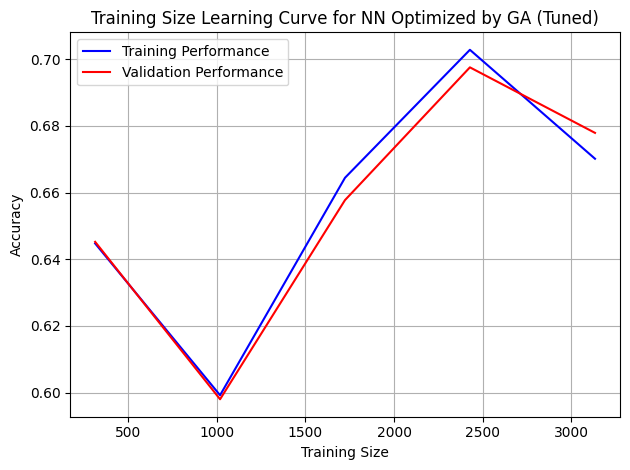

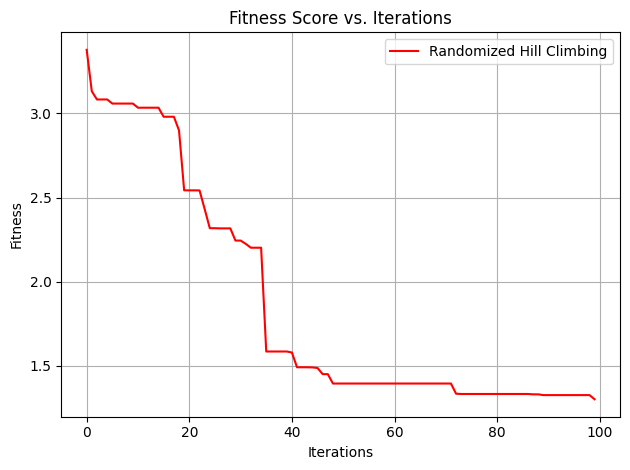

In [56]:
'''
Source: https://github.com/hiive/mlrose/blob/master/mlrose_hiive/neural/neural_network.py

'''

rhc_mlp_clf = mlrose.NeuralNetwork(early_stopping=True, hidden_nodes=(25, 25), learning_rate=10,
              max_attempts=100, random_state=37, restarts=50, curve=True)


# start timer for training
start = time.time()
# train classifier
rhc_mlp_clf.fit(X_train, y_train)
# end timer for training
end = time.time()
# print total time for training
print(f"Total Training Time: {round(end-start, 5)}s")

# start timer for testing
start = time.time()
# make prediction
y_pred = rhc_mlp_clf.predict(X_test)
# end timer for testing
end = time.time()
# print total time for testing
print(f"Total Testing Time: {round(end-start, 5)}s")

# evaluate model performance on test data
print("Accuracy using test set:", accuracy_score(y_test, y_pred))
# evaluate model performance using confusion_matrix
print(confusion_matrix(y_test, y_pred))
# evaluate model performance using classification_report
print(classification_report(y_test, y_pred))
# evaluate model performance using cross-validation
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)
cv_scores = cross_val_score(rhc_mlp_clf, X, y, cv=skfold, scoring='accuracy')
print("Accuracy using cross-validation:", cv_scores.mean())

# Total Training Time: 199.16774s
# Total Testing Time: 0.001s
# Accuracy using test set: 0.3173469387755102
# [[300  13]
#  [656  11]]
#               precision    recall  f1-score   support

#            0       0.31      0.96      0.47       313
#            1       0.46      0.02      0.03       667

#     accuracy                           0.32       980
#    macro avg       0.39      0.49      0.25       980
# weighted avg       0.41      0.32      0.17       980


# plot learning curve using training and validation data
get_learning_curve_size(clf=rhc_mlp_clf, clf_name="NN Optimized by GA (Tuned)", X=X_train, y=y_train)

# plot and show
fitness_curve = rhc_mlp_clf.fitness_curve
plt.plot(fitness_curve[:,0], color="red", label="Randomized Hill Climbing")
plt.title("Fitness Score vs. Iterations")
plt.xlabel("Iterations"), plt.ylabel("Fitness"), plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.show()

Total Training Time: 0.271s
Total Testing Time: 0.001s
Accuracy using test set: 0.6806122448979591
[[  0 313]
 [  0 667]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       313
           1       0.68      1.00      0.81       667

    accuracy                           0.68       980
   macro avg       0.34      0.50      0.40       980
weighted avg       0.46      0.68      0.55       980

Accuracy using cross-validation: 0.6651693731629525


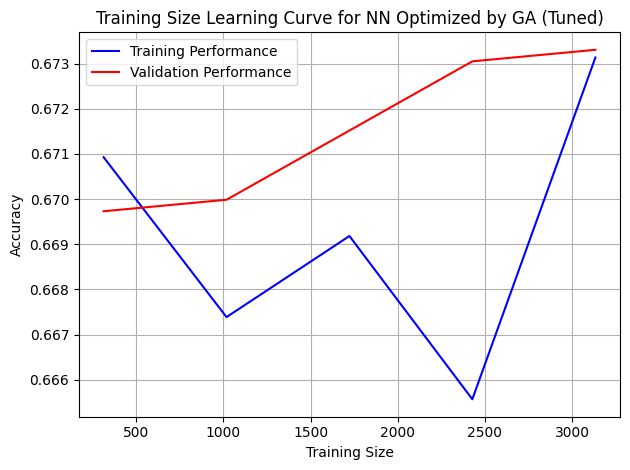

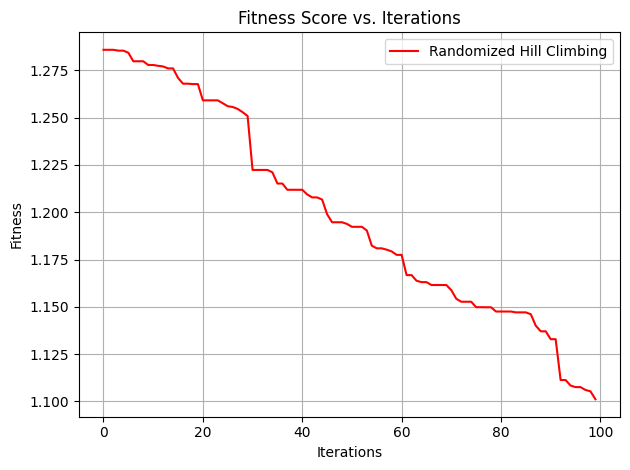

In [57]:
'''
Source: https://github.com/hiive/mlrose/blob/master/mlrose_hiive/neural/neural_network.py

'''

rhc_mlp_clf = mlrose.NeuralNetwork(hidden_nodes=[25],
                                  activation='relu',
                                  algorithm='random_hill_climb',
                                  max_iters=100,
                                  bias=True,
                                  is_classifier=True,
                                  learning_rate=.1,
                                  early_stopping=True,
                                  restarts=0,
                                  max_attempts=10,
                                  random_state=37,
                                  curve=True)


# start timer for training
start = time.time()
# train classifier
rhc_mlp_clf.fit(X_train, y_train)
# end timer for training
end = time.time()
# print total time for training
print(f"Total Training Time: {round(end-start, 5)}s")

# start timer for testing
start = time.time()
# make prediction
y_pred = rhc_mlp_clf.predict(X_test)
# end timer for testing
end = time.time()
# print total time for testing
print(f"Total Testing Time: {round(end-start, 5)}s")

# evaluate model performance on test data
print("Accuracy using test set:", accuracy_score(y_test, y_pred))
# evaluate model performance using confusion_matrix
print(confusion_matrix(y_test, y_pred))
# evaluate model performance using classification_report
print(classification_report(y_test, y_pred))
# evaluate model performance using cross-validation
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)
cv_scores = cross_val_score(rhc_mlp_clf, X, y, cv=skfold, scoring='accuracy')
print("Accuracy using cross-validation:", cv_scores.mean())

# Total Training Time: 199.16774s
# Total Testing Time: 0.001s
# Accuracy using test set: 0.3173469387755102
# [[300  13]
#  [656  11]]
#               precision    recall  f1-score   support

#            0       0.31      0.96      0.47       313
#            1       0.46      0.02      0.03       667

#     accuracy                           0.32       980
#    macro avg       0.39      0.49      0.25       980
# weighted avg       0.41      0.32      0.17       980


# plot learning curve using training and validation data
get_learning_curve_size(clf=rhc_mlp_clf, clf_name="NN Optimized by RHC (Tuned)", X=X_train, y=y_train)

# plot and show
fitness_curve = rhc_mlp_clf.fitness_curve
plt.plot(fitness_curve[:,0], color="red", label="Randomized Hill Climbing")
plt.title("Fitness Score vs. Iterations")
plt.xlabel("Iterations"), plt.ylabel("Fitness"), plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.show()

***
### 3. Simulated Annealing
*** 

In [34]:
'''
Source: https://github.com/hiive/mlrose/blob/master/mlrose_hiive/neural/neural_network.py

'''

sa_mlp_clf = mlrose.NeuralNetwork(hidden_nodes=[25],
                                  activation='relu',
                                  algorithm='simulated_annealing',
                                  max_iters=1000,
                                  bias=True,
                                  is_classifier=True,
                                  learning_rate=1,
                                  early_stopping=True,
                                  clip_max=5,
                                  schedule=mlrose.ExpDecay(),
                                  max_attempts=100,
                                  random_state=37,
                                  curve=False)

In [35]:
# start timer for training
start = time.time()
# train classifier
sa_mlp_clf.fit(X_train, y_train)
# end timer for training
end = time.time()
# print total time for training
print(f"Total Training Time: {round(end-start, 5)}s")

# start timer for testing
start = time.time()
# make prediction
y_pred = sa_mlp_clf.predict(X_test)
# end timer for testing
end = time.time()
# print total time for testing
print(f"Total Testing Time: {round(end-start, 5)}s")

# evaluate model performance on test data
print("Accuracy using test set:", accuracy_score(y_test, y_pred))
# evaluate model performance using confusion_matrix
print(confusion_matrix(y_test, y_pred))
# evaluate model performance using classification_report
print(classification_report(y_test, y_pred))

Total Training Time: 4.47707s
Total Testing Time: 0.001s
Accuracy using test set: 0.5918367346938775
[[157 156]
 [244 423]]
              precision    recall  f1-score   support

           0       0.39      0.50      0.44       313
           1       0.73      0.63      0.68       667

    accuracy                           0.59       980
   macro avg       0.56      0.57      0.56       980
weighted avg       0.62      0.59      0.60       980



In [14]:
'''
Source: https://github.com/hiive/mlrose/blob/master/mlrose_hiive/neural/neural_network.py

'''

sa_mlp_clf = mlrose.NeuralNetwork(hidden_nodes=(50, 50),
                                  activation='relu',
                                  algorithm='simulated_annealing',
                                  max_iters=1000,
                                  bias=True,
                                  is_classifier=True,
                                  learning_rate=1,
                                  early_stopping=True,
                                  clip_max=5,
                                  schedule=mlrose.ExpDecay(init_temp=1.0, exp_const=0.005, min_temp=0.001),
                                  max_attempts=100,
                                  random_state=37,
                                  curve=False)

In [15]:
# start timer for training
start = time.time()
# train classifier
sa_mlp_clf.fit(X_train, y_train)
# end timer for training
end = time.time()
# print total time for training
print(f"Total Training Time: {round(end-start, 5)}s")

# start timer for testing
start = time.time()
# make prediction
y_pred = sa_mlp_clf.predict(X_test)
# end timer for testing
end = time.time()
# print total time for testing
print(f"Total Testing Time: {round(end-start, 5)}s")

# evaluate model performance on test data
print("Accuracy using test set:", accuracy_score(y_test, y_pred))
# evaluate model performance using confusion_matrix
print(confusion_matrix(y_test, y_pred))
# evaluate model performance using classification_report
print(classification_report(y_test, y_pred))

Total Training Time: 12.93642s
Total Testing Time: 0.00199s
Accuracy using test set: 0.6836734693877551
[[  3 310]
 [  0 667]]
              precision    recall  f1-score   support

           0       1.00      0.01      0.02       313
           1       0.68      1.00      0.81       667

    accuracy                           0.68       980
   macro avg       0.84      0.50      0.42       980
weighted avg       0.78      0.68      0.56       980



In [ ]:
"""
Neural Network (hyperparameter optimization and confirmation) using Gridsearch

"""

sa_mlp_clf = mlrose.NeuralNetwork(hidden_nodes=[25],
                                  activation='relu',
                                  algorithm='simulated_annealing',
                                  max_iters=1000,
                                  bias=True,
                                  is_classifier=True,
                                  learning_rate=1,
                                  early_stopping=False,
                                  schedule=mlrose.ExpDecay(),
                                  max_attempts=100,
                                  random_state=37,
                                  curve=False)

# list hyperparameters to compare
h_params = {
    'hidden_nodes':[
        (100),
        (100, 100),
        (50),
        (50, 50),
        (50, 50, 50)
    ],
    'learning_rate':[.001, .01, 1],
    'max_iters': [200, 400, 600, 800, 1000]
}

# intialize grid search
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)
grid_search = GridSearchCV(sa_mlp_clf, h_params, cv=skfold, scoring='accuracy')

# fit grid search
grid_search.fit(X_train, y_train)

# return grid search results
print("According to gridsearch")
print("Best parameter values:", grid_search.best_params_)
print("Best classifier:", grid_search.best_estimator_)
print("Best score:", grid_search.best_score_)

# According to gridsearch
# Best parameter values: {'hidden_nodes': (50, 50), 'learning_rate': 1, 'max_iters': 1000}
# Best classifier: NeuralNetwork(algorithm='simulated_annealing', hidden_nodes=(50, 50),
#               learning_rate=1, max_attempts=100, max_iters=1000,
#               random_state=37,
#               schedule=ExpDecay(init_temp=1.0, exp_const=0.005, min_temp=0.001))
# Best score: 0.6870810201475226

Total Training Time: 13.15218s
Total Testing Time: 0.00199s
Accuracy using test set: 0.6836734693877551
[[  3 310]
 [  0 667]]
              precision    recall  f1-score   support

           0       1.00      0.01      0.02       313
           1       0.68      1.00      0.81       667

    accuracy                           0.68       980
   macro avg       0.84      0.50      0.42       980
weighted avg       0.78      0.68      0.56       980



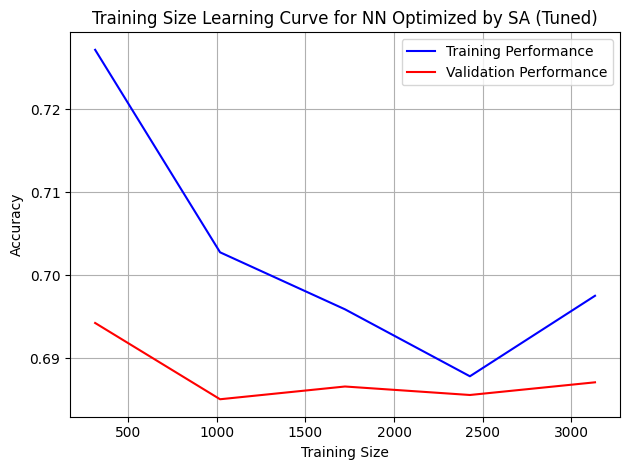

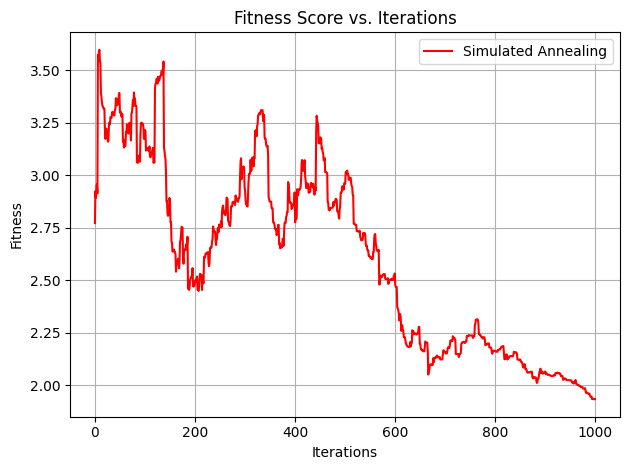

In [60]:
"""
Neural Network - Final Learning Curve

"""
# initialize with a seed
sa_mlp_clf = mlrose.NeuralNetwork(hidden_nodes=(50, 50),
                                  activation='relu',
                                  algorithm='simulated_annealing',
                                  max_iters=1000,
                                  bias=True,
                                  is_classifier=True,
                                  learning_rate=1,
                                  early_stopping=True,
                                  clip_max=5,
                                  schedule=mlrose.ExpDecay(init_temp=1.0, exp_const=0.005, min_temp=0.001),
                                  max_attempts=100,
                                  random_state=37,
                                  curve=True)

# start timer for training
start = time.time()
# train classifier
sa_mlp_clf.fit(X_train, y_train)
# end timer for training
end = time.time()
# print total time for training
print(f"Total Training Time: {round(end-start, 5)}s")

# start timer for testing
start = time.time()
# make prediction
y_pred = sa_mlp_clf.predict(X_test)
# end timer for testing
end = time.time()
# print total time for testing
print(f"Total Testing Time: {round(end-start, 5)}s")

# evaluate model performance on test data
print("Accuracy using test set:", accuracy_score(y_test, y_pred))
# evaluate model performance using confusion_matrix
print(confusion_matrix(y_test, y_pred))
# evaluate model performance using classification_report
print(classification_report(y_test, y_pred))

# plot learning curve using training and validation data
get_learning_curve_size(clf=sa_mlp_clf, clf_name="NN Optimized by SA (Tuned)", X=X_train, y=y_train)
# plot loss curve using using training data
# plot and show
fitness_curve = sa_mlp_clf.fitness_curve
plt.plot(fitness_curve[:,0], color="red", label="Simulated Annealing")
plt.title("Fitness Score vs. Iterations")
plt.xlabel("Iterations"), plt.ylabel("Fitness"), plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.show()



In [17]:
sa_mlp_clf

NeuralNetwork(algorithm='simulated_annealing', clip_max=5, early_stopping=True,
              hidden_nodes=(50, 50), learning_rate=1, max_attempts=100,
              max_iters=1000, random_state=37,
              schedule=ExpDecay(init_temp=1.0, exp_const=0.005, min_temp=0.001))

***
### 4. Genetic Algorithms
*** 

In [18]:
'''
Source: https://github.com/hiive/mlrose/blob/master/mlrose_hiive/neural/neural_network.py

'''

ga_mlp_clf = mlrose.NeuralNetwork(hidden_nodes=[25],
                                  activation='relu',
                                  algorithm='genetic_alg',
                                  max_iters=100,
                                  bias=True,
                                  is_classifier=True,
                                  learning_rate=0.1,
                                  early_stopping=False,
                                  pop_size=200,
                                  mutation_prob=0.1,
                                  max_attempts=10,
                                  random_state=37,
                                  curve=False)

# start timer for training
start = time.time()
# train classifier
ga_mlp_clf.fit(X_train, y_train)
# end timer for training
end = time.time()
# print total time for training
print(f"Total Training Time: {round(end-start, 5)}s")

# start timer for testing
start = time.time()
# make prediction
y_pred = ga_mlp_clf.predict(X_test)
# end timer for testing
end = time.time()
# print total time for testing
print(f"Total Testing Time: {round(end-start, 5)}s")

# evaluate model performance on test data
print("Accuracy using test set:", accuracy_score(y_test, y_pred))
# evaluate model performance using confusion_matrix
print(confusion_matrix(y_test, y_pred))
# evaluate model performance using classification_report
print(classification_report(y_test, y_pred))

Total Training Time: 42.83963s
Total Testing Time: 0.0s
Accuracy using test set: 0.4387755102040816
[[262  51]
 [499 168]]
              precision    recall  f1-score   support

           0       0.34      0.84      0.49       313
           1       0.77      0.25      0.38       667

    accuracy                           0.44       980
   macro avg       0.56      0.54      0.43       980
weighted avg       0.63      0.44      0.41       980



In [20]:
'''
Source: https://github.com/hiive/mlrose/blob/master/mlrose_hiive/neural/neural_network.py

'''

ga_mlp_clf = mlrose.NeuralNetwork(hidden_nodes=[25],
                                  activation='relu',
                                  algorithm='genetic_alg',
                                  max_iters=100,
                                  bias=True,
                                  is_classifier=True,
                                  learning_rate=0.1,
                                  early_stopping=False,
                                  pop_size=200,
                                  mutation_prob=0.4,
                                  max_attempts=10,
                                  random_state=37,
                                  curve=False)

# start timer for training
start = time.time()
# train classifier
ga_mlp_clf.fit(X_train, y_train)
# end timer for training
end = time.time()
# print total time for training
print(f"Total Training Time: {round(end-start, 5)}s")

# start timer for testing
start = time.time()
# make prediction
y_pred = ga_mlp_clf.predict(X_test)
# end timer for testing
end = time.time()
# print total time for testing
print(f"Total Testing Time: {round(end-start, 5)}s")

# evaluate model performance on test data
print("Accuracy using test set:", accuracy_score(y_test, y_pred))
# evaluate model performance using confusion_matrix
print(confusion_matrix(y_test, y_pred))
# evaluate model performance using classification_report
print(classification_report(y_test, y_pred))

Total Training Time: 41.99075s
Total Testing Time: 0.0s
Accuracy using test set: 0.6806122448979591
[[  0 313]
 [  0 667]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       313
           1       0.68      1.00      0.81       667

    accuracy                           0.68       980
   macro avg       0.34      0.50      0.40       980
weighted avg       0.46      0.68      0.55       980



In [19]:
'''
Source: https://github.com/hiive/mlrose/blob/master/mlrose_hiive/neural/neural_network.py

'''

ga_mlp_clf = mlrose.NeuralNetwork(hidden_nodes=[25],
                                  activation='relu',
                                  algorithm='genetic_alg',
                                  max_iters=1000,
                                  bias=True,
                                  is_classifier=True,
                                  learning_rate=1,
                                  early_stopping=True,
                                  pop_size=200,
                                  mutation_prob=0.4,
                                  max_attempts=100,
                                  random_state=37,
                                  curve=False)

# start timer for training
start = time.time()
# train classifier
ga_mlp_clf.fit(X_train, y_train)
# end timer for training
end = time.time()
# print total time for training
print(f"Total Training Time: {round(end-start, 5)}s")

# start timer for testing
start = time.time()
# make prediction
y_pred = ga_mlp_clf.predict(X_test)
# end timer for testing
end = time.time()
# print total time for testing
print(f"Total Testing Time: {round(end-start, 5)}s")

# evaluate model performance on test data
print("Accuracy using test set:", accuracy_score(y_test, y_pred))
# evaluate model performance using confusion_matrix
print(confusion_matrix(y_test, y_pred))
# evaluate model performance using classification_report
print(classification_report(y_test, y_pred))

Total Training Time: 93.50697s
Total Testing Time: 0.0s
Accuracy using test set: 0.6806122448979591
[[  0 313]
 [  0 667]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       313
           1       0.68      1.00      0.81       667

    accuracy                           0.68       980
   macro avg       0.34      0.50      0.40       980
weighted avg       0.46      0.68      0.55       980



In [ ]:
'''
Source: https://github.com/hiive/mlrose/blob/master/mlrose_hiive/neural/neural_network.py

'''

ga_mlp_clf = mlrose.NeuralNetwork(hidden_nodes=[100],
                                  activation='relu',
                                  algorithm='genetic_alg',
                                  max_iters=100,
                                  bias=True,
                                  is_classifier=True,
                                  learning_rate=1,
                                  early_stopping=True,
                                  pop_size=200,
                                  mutation_prob=0.4,
                                  max_attempts=100,
                                  random_state=37,
                                  curve=False)

# start timer for training
start = time.time()
# train classifier
ga_mlp_clf.fit(X_train, y_train)
# end timer for training
end = time.time()
# print total time for training
print(f"Total Training Time: {round(end-start, 5)}s")

# start timer for testing
start = time.time()
# make prediction
y_pred = ga_mlp_clf.predict(X_test)
# end timer for testing
end = time.time()
# print total time for testing
print(f"Total Testing Time: {round(end-start, 5)}s")

# evaluate model performance on test data
print("Accuracy using test set:", accuracy_score(y_test, y_pred))
# evaluate model performance using confusion_matrix
print(confusion_matrix(y_test, y_pred))
# evaluate model performance using classification_report
print(classification_report(y_test, y_pred))

# Total Training Time: 150.31697s
# Total Testing Time: 0.00502s
# Accuracy using test set: 0.6653061224489796
# [[  4 309]
#  [ 19 648]]
#               precision    recall  f1-score   support

#            0       0.17      0.01      0.02       313
#            1       0.68      0.97      0.80       667

#     accuracy                           0.67       980
#    macro avg       0.43      0.49      0.41       980
# weighted avg       0.52      0.67      0.55       980

In [ ]:
'''
Source: https://github.com/hiive/mlrose/blob/master/mlrose_hiive/neural/neural_network.py

'''

ga_mlp_clf = mlrose.NeuralNetwork(hidden_nodes=[100, 100],
                                  activation='relu',
                                  algorithm='genetic_alg',
                                  max_iters=100,
                                  bias=True,
                                  is_classifier=True,
                                  learning_rate=1,
                                  early_stopping=True,
                                  pop_size=200,
                                  mutation_prob=0.4,
                                  max_attempts=100,
                                  random_state=37,
                                  curve=False)

# start timer for training
start = time.time()
# train classifier
ga_mlp_clf.fit(X_train, y_train)
# end timer for training
end = time.time()
# print total time for training
print(f"Total Training Time: {round(end-start, 5)}s")

# start timer for testing
start = time.time()
# make prediction
y_pred = ga_mlp_clf.predict(X_test)
# end timer for testing
end = time.time()
# print total time for testing
print(f"Total Testing Time: {round(end-start, 5)}s")

# evaluate model performance on test data
print("Accuracy using test set:", accuracy_score(y_test, y_pred))
# evaluate model performance using confusion_matrix
print(confusion_matrix(y_test, y_pred))
# evaluate model performance using classification_report
print(classification_report(y_test, y_pred))

# Total Training Time: 362.87526s
# Total Testing Time: 0.00301s
# Accuracy using test set: 0.6795918367346939
# [[  0 313]
#  [  1 666]]
#               precision    recall  f1-score   support

#            0       0.00      0.00      0.00       313
#            1       0.68      1.00      0.81       667

#     accuracy                           0.68       980
#    macro avg       0.34      0.50      0.40       980
# weighted avg       0.46      0.68      0.55       980

In [ ]:
'''
Source: https://github.com/hiive/mlrose/blob/master/mlrose_hiive/neural/neural_network.py

'''

ga_mlp_clf = mlrose.NeuralNetwork(hidden_nodes=[25, 25],
                                  activation='relu',
                                  algorithm='genetic_alg',
                                  max_iters=100,
                                  bias=True,
                                  is_classifier=True,
                                  learning_rate=1,
                                  early_stopping=True,
                                  pop_size=200,
                                  mutation_prob=0.4,
                                  max_attempts=100,
                                  random_state=37,
                                  curve=False)

# start timer for training
start = time.time()
# train classifier
ga_mlp_clf.fit(X_train, y_train)
# end timer for training
end = time.time()
# print total time for training
print(f"Total Training Time: {round(end-start, 5)}s")

# start timer for testing
start = time.time()
# make prediction
y_pred = ga_mlp_clf.predict(X_test)
# end timer for testing
end = time.time()
# print total time for testing
print(f"Total Testing Time: {round(end-start, 5)}s")

# evaluate model performance on test data
print("Accuracy using test set:", accuracy_score(y_test, y_pred))
# evaluate model performance using confusion_matrix
print(confusion_matrix(y_test, y_pred))
# evaluate model performance using classification_report
print(classification_report(y_test, y_pred))

# Total Training Time: 77.60169s
# Total Testing Time: 0.001s
# Accuracy using test set: 0.6806122448979591
# [[  0 313]
#  [  0 667]]
#               precision    recall  f1-score   support

#            0       0.00      0.00      0.00       313
#            1       0.68      1.00      0.81       667

#     accuracy                           0.68       980
#    macro avg       0.34      0.50      0.40       980
# weighted avg       0.46      0.68      0.55       980

In [ ]:
'''
Source: https://github.com/hiive/mlrose/blob/master/mlrose_hiive/neural/neural_network.py

'''

ga_mlp_clf = mlrose.NeuralNetwork(hidden_nodes=[15],
                                  activation='relu',
                                  algorithm='genetic_alg',
                                  max_iters=100,
                                  bias=True,
                                  is_classifier=True,
                                  learning_rate=1,
                                  early_stopping=True,
                                  pop_size=200,
                                  mutation_prob=0.4,
                                  max_attempts=100,
                                  random_state=37,
                                  curve=False)

# start timer for training
start = time.time()
# train classifier
ga_mlp_clf.fit(X_train, y_train)
# end timer for training
end = time.time()
# print total time for training
print(f"Total Training Time: {round(end-start, 5)}s")

# start timer for testing
start = time.time()
# make prediction
y_pred = ga_mlp_clf.predict(X_test)
# end timer for testing
end = time.time()
# print total time for testing
print(f"Total Testing Time: {round(end-start, 5)}s")

# evaluate model performance on test data
print("Accuracy using test set:", accuracy_score(y_test, y_pred))
# evaluate model performance using confusion_matrix
print(confusion_matrix(y_test, y_pred))
# evaluate model performance using classification_report
print(classification_report(y_test, y_pred))

# Total Training Time: 33.4787s
# Total Testing Time: 0.0s
# Accuracy using test set: 0.30306122448979594
# [[265  48]
#  [635  32]]
#               precision    recall  f1-score   support

#            0       0.29      0.85      0.44       313
#            1       0.40      0.05      0.09       667

#     accuracy                           0.30       980
#    macro avg       0.35      0.45      0.26       980
# weighted avg       0.37      0.30      0.20       980

In [ ]:
'''
Source: https://github.com/hiive/mlrose/blob/master/mlrose_hiive/neural/neural_network.py

'''

ga_mlp_clf = mlrose.NeuralNetwork(hidden_nodes=[25],
                                  activation='relu',
                                  algorithm='genetic_alg',
                                  max_iters=100,
                                  bias=True,
                                  is_classifier=True,
                                  learning_rate=1,
                                  early_stopping=True,
                                  pop_size=300,
                                  mutation_prob=0.4,
                                  max_attempts=100,
                                  random_state=37,
                                  curve=False)

# start timer for training
start = time.time()
# train classifier
ga_mlp_clf.fit(X_train, y_train)
# end timer for training
end = time.time()
# print total time for training
print(f"Total Training Time: {round(end-start, 5)}s")

# start timer for testing
start = time.time()
# make prediction
y_pred = ga_mlp_clf.predict(X_test)
# end timer for testing
end = time.time()
# print total time for testing
print(f"Total Testing Time: {round(end-start, 5)}s")

# evaluate model performance on test data
print("Accuracy using test set:", accuracy_score(y_test, y_pred))
# evaluate model performance using confusion_matrix
print(confusion_matrix(y_test, y_pred))
# evaluate model performance using classification_report
print(classification_report(y_test, y_pred))

# Total Training Time: 66.87968s
# Total Testing Time: 0.001s
# Accuracy using test set: 0.6806122448979591
# [[  0 313]
#  [  0 667]]
#               precision    recall  f1-score   support

#            0       0.00      0.00      0.00       313
#            1       0.68      1.00      0.81       667

#     accuracy                           0.68       980
#    macro avg       0.34      0.50      0.40       980
# weighted avg       0.46      0.68      0.55       980

In [ ]:
'''
Source: https://github.com/hiive/mlrose/blob/master/mlrose_hiive/neural/neural_network.py

'''

ga_mlp_clf = mlrose.NeuralNetwork(hidden_nodes=[25],
                                  activation='relu',
                                  algorithm='genetic_alg',
                                  max_iters=100,
                                  bias=True,
                                  is_classifier=True,
                                  learning_rate=1,
                                  early_stopping=True,
                                  pop_size=100,
                                  mutation_prob=0.4,
                                  max_attempts=100,
                                  random_state=37,
                                  curve=False)

# start timer for training
start = time.time()
# train classifier
ga_mlp_clf.fit(X_train, y_train)
# end timer for training
end = time.time()
# print total time for training
print(f"Total Training Time: {round(end-start, 5)}s")

# start timer for testing
start = time.time()
# make prediction
y_pred = ga_mlp_clf.predict(X_test)
# end timer for testing
end = time.time()
# print total time for testing
print(f"Total Testing Time: {round(end-start, 5)}s")

# evaluate model performance on test data
print("Accuracy using test set:", accuracy_score(y_test, y_pred))
# evaluate model performance using confusion_matrix
print(confusion_matrix(y_test, y_pred))
# evaluate model performance using classification_report
print(classification_report(y_test, y_pred))


# Total Training Time: 22.63327s
# Total Testing Time: 0.00197s
# Accuracy using test set: 0.32040816326530613
# [[313   0]
#  [666   1]]
#               precision    recall  f1-score   support

#            0       0.32      1.00      0.48       313
#            1       1.00      0.00      0.00       667

#     accuracy                           0.32       980
#    macro avg       0.66      0.50      0.24       980
# weighted avg       0.78      0.32      0.16       980

In [ ]:
'''
Source: https://github.com/hiive/mlrose/blob/master/mlrose_hiive/neural/neural_network.py

'''

ga_mlp_clf = mlrose.NeuralNetwork(hidden_nodes=[25],
                                  activation='relu',
                                  algorithm='genetic_alg',
                                  max_iters=100,
                                  bias=True,
                                  is_classifier=True,
                                  learning_rate=1,
                                  early_stopping=True,
                                  pop_size=100,
                                  mutation_prob=0.5,
                                  max_attempts=100,
                                  random_state=37,
                                  curve=False)

# start timer for training
start = time.time()
# train classifier
ga_mlp_clf.fit(X_train, y_train)
# end timer for training
end = time.time()
# print total time for training
print(f"Total Training Time: {round(end-start, 5)}s")

# start timer for testing
start = time.time()
# make prediction
y_pred = ga_mlp_clf.predict(X_test)
# end timer for testing
end = time.time()
# print total time for testing
print(f"Total Testing Time: {round(end-start, 5)}s")

# evaluate model performance on test data
print("Accuracy using test set:", accuracy_score(y_test, y_pred))
# evaluate model performance using confusion_matrix
print(confusion_matrix(y_test, y_pred))
# evaluate model performance using classification_report
print(classification_report(y_test, y_pred))

# Total Training Time: 22.65003s
# Total Testing Time: 0.001s
# Accuracy using test set: 0.4030612244897959
# [[234  79]
#  [506 161]]
#               precision    recall  f1-score   support

#            0       0.32      0.75      0.44       313
#            1       0.67      0.24      0.36       667

#     accuracy                           0.40       980
#    macro avg       0.49      0.49      0.40       980
# weighted avg       0.56      0.40      0.38       980

In [ ]:
'''
Source: https://github.com/hiive/mlrose/blob/master/mlrose_hiive/neural/neural_network.py

'''

ga_mlp_clf = mlrose.NeuralNetwork(hidden_nodes=[25],
                                  activation='relu',
                                  algorithm='genetic_alg',
                                  max_iters=100,
                                  bias=True,
                                  is_classifier=True,
                                  learning_rate=1,
                                  early_stopping=True,
                                  pop_size=200,
                                  mutation_prob=0.4,
                                  max_attempts=100,
                                  random_state=37,
                                  curve=False)

# start timer for training
start = time.time()
# train classifier
ga_mlp_clf.fit(X_train, y_train)
# end timer for training
end = time.time()
# print total time for training
print(f"Total Training Time: {round(end-start, 5)}s")

# start timer for testing
start = time.time()
# make prediction
y_pred = ga_mlp_clf.predict(X_test)
# end timer for testing
end = time.time()
# print total time for testing
print(f"Total Testing Time: {round(end-start, 5)}s")

# evaluate model performance on test data
print("Accuracy using test set:", accuracy_score(y_test, y_pred))
# evaluate model performance using confusion_matrix
print(confusion_matrix(y_test, y_pred))
# evaluate model performance using classification_report
print(classification_report(y_test, y_pred))

# Total Training Time: 44.73994s
# Total Testing Time: 0.0s
# Accuracy using test set: 0.6806122448979591
# [[  0 313]
#  [  0 667]]
#               precision    recall  f1-score   support

#            0       0.00      0.00      0.00       313
#            1       0.68      1.00      0.81       667

#     accuracy                           0.68       980
#    macro avg       0.34      0.50      0.40       980
# weighted avg       0.46      0.68      0.55       980

In [ ]:
'''
Source: https://github.com/hiive/mlrose/blob/master/mlrose_hiive/neural/neural_network.py

'''

ga_mlp_clf = mlrose.NeuralNetwork(hidden_nodes=[25],
                                  activation='relu',
                                  algorithm='genetic_alg',
                                  max_iters=100,
                                  bias=True,
                                  is_classifier=True,
                                  learning_rate=1,
                                  early_stopping=True,
                                  pop_size=200,
                                  mutation_prob=0.3,
                                  max_attempts=100,
                                  random_state=37,
                                  curve=False)

# start timer for training
start = time.time()
# train classifier
ga_mlp_clf.fit(X_train, y_train)
# end timer for training
end = time.time()
# print total time for training
print(f"Total Training Time: {round(end-start, 5)}s")

# start timer for testing
start = time.time()
# make prediction
y_pred = ga_mlp_clf.predict(X_test)
# end timer for testing
end = time.time()
# print total time for testing
print(f"Total Testing Time: {round(end-start, 5)}s")

# evaluate model performance on test data
print("Accuracy using test set:", accuracy_score(y_test, y_pred))
# evaluate model performance using confusion_matrix
print(confusion_matrix(y_test, y_pred))
# evaluate model performance using classification_report
print(classification_report(y_test, y_pred))

# Total Training Time: 43.68509s
# Total Testing Time: 0.001s
# Accuracy using test set: 0.6591836734693878
# [[ 79 234]
#  [100 567]]
#               precision    recall  f1-score   support

#            0       0.44      0.25      0.32       313
#            1       0.71      0.85      0.77       667

#     accuracy                           0.66       980
#    macro avg       0.57      0.55      0.55       980
# weighted avg       0.62      0.66      0.63       980

In [ ]:
'''
Source: https://github.com/hiive/mlrose/blob/master/mlrose_hiive/neural/neural_network.py

'''

ga_mlp_clf = mlrose.NeuralNetwork(hidden_nodes=[25],
                                  activation='relu',
                                  algorithm='genetic_alg',
                                  max_iters=100,
                                  bias=True,
                                  is_classifier=True,
                                  learning_rate=10,
                                  early_stopping=True,
                                  pop_size=200,
                                  mutation_prob=0.3,
                                  max_attempts=100,
                                  random_state=37,
                                  curve=False)

# start timer for training
start = time.time()
# train classifier
ga_mlp_clf.fit(X_train, y_train)
# end timer for training
end = time.time()
# print total time for training
print(f"Total Training Time: {round(end-start, 5)}s")

# start timer for testing
start = time.time()
# make prediction
y_pred = ga_mlp_clf.predict(X_test)
# end timer for testing
end = time.time()
# print total time for testing
print(f"Total Testing Time: {round(end-start, 5)}s")

# evaluate model performance on test data
print("Accuracy using test set:", accuracy_score(y_test, y_pred))
# evaluate model performance using confusion_matrix
print(confusion_matrix(y_test, y_pred))
# evaluate model performance using classification_report
print(classification_report(y_test, y_pred))

# Total Training Time: 43.70277s
# Total Testing Time: 0.0s
# Accuracy using test set: 0.6591836734693878
# [[ 79 234]
#  [100 567]]
#               precision    recall  f1-score   support

#            0       0.44      0.25      0.32       313
#            1       0.71      0.85      0.77       667

#     accuracy                           0.66       980
#    macro avg       0.57      0.55      0.55       980
# weighted avg       0.62      0.66      0.63       980

Total Training Time: 59.03396s
Total Testing Time: 0.001s
Accuracy using test set: 0.3224489795918367
[[304   9]
 [655  12]]
              precision    recall  f1-score   support

           0       0.32      0.97      0.48       313
           1       0.57      0.02      0.03       667

    accuracy                           0.32       980
   macro avg       0.44      0.49      0.26       980
weighted avg       0.49      0.32      0.18       980

Accuracy using cross-validation: 0.6841606387192263


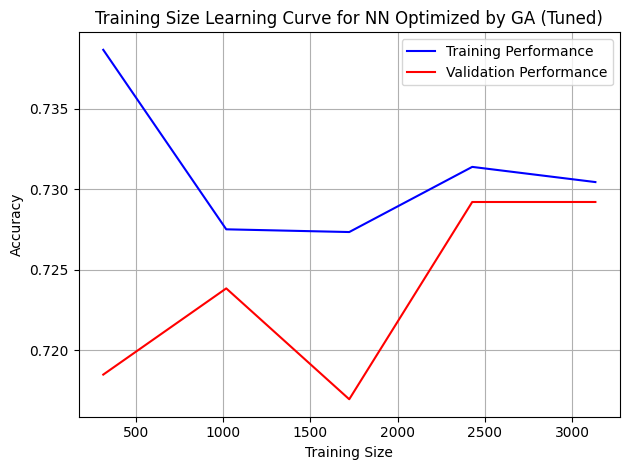

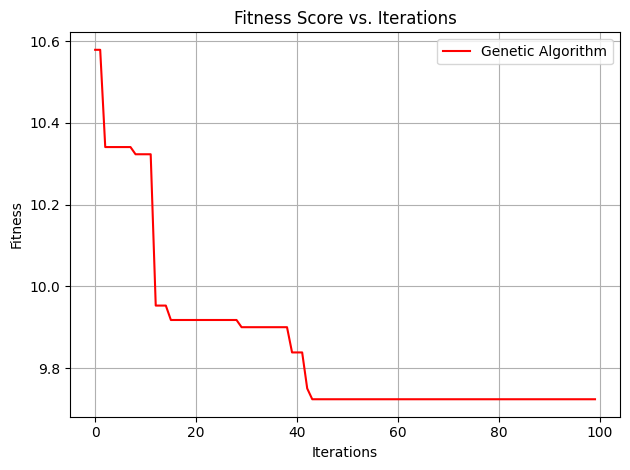

In [58]:
'''
Source: https://github.com/hiive/mlrose/blob/master/mlrose_hiive/neural/neural_network.py

'''

ga_mlp_clf = mlrose.NeuralNetwork(hidden_nodes=[25],
                                  activation='relu',
                                  algorithm='genetic_alg',
                                  max_iters=100,
                                  bias=True,
                                  is_classifier=True,
                                  learning_rate=10,
                                  early_stopping=True,
                                  pop_size=300,
                                  mutation_prob=0.3,
                                  max_attempts=100,
                                  random_state=37,
                                  curve=True)

# start timer for training
start = time.time()
# train classifier
ga_mlp_clf.fit(X_train, y_train)
# end timer for training
end = time.time()
# print total time for training
print(f"Total Training Time: {round(end-start, 5)}s")

# start timer for testing
start = time.time()
# make prediction
y_pred = ga_mlp_clf.predict(X_test)
# end timer for testing
end = time.time()
# print total time for testing
print(f"Total Testing Time: {round(end-start, 5)}s")

# evaluate model performance on test data
print("Accuracy using test set:", accuracy_score(y_test, y_pred))
# evaluate model performance using confusion_matrix
print(confusion_matrix(y_test, y_pred))
# evaluate model performance using classification_report
print(classification_report(y_test, y_pred))
# evaluate model performance using cross-validation
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)
cv_scores = cross_val_score(ga_mlp_clf, X, y, cv=skfold, scoring='accuracy')
print("Accuracy using cross-validation:", cv_scores.mean())

# plot learning curve using training and validation data
get_learning_curve_size(clf=ga_mlp_clf, clf_name="NN Optimized by GA (Tuned)", X=X_train, y=y_train)
# plot loss curve using using training data
# plot and show
fitness_curve = ga_mlp_clf.fitness_curve
plt.plot(fitness_curve[:,0], color="red", label="Genetic Algorithm")
plt.title("Fitness Score vs. Iterations")
plt.xlabel("Iterations"), plt.ylabel("Fitness"), plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.show()

In [22]:
"""
Neural Network (hyperparameter optimization and confirmation) using Gridsearch

"""

ga_mlp_clf = mlrose.NeuralNetwork(hidden_nodes=[25],
                                  activation='relu',
                                  algorithm='genetic_alg',
                                  max_iters=100,
                                  bias=True,
                                  is_classifier=True,
                                  learning_rate=1,
                                  early_stopping=True,
                                  pop_size=200,
                                  mutation_prob=0.4,
                                  max_attempts=100,
                                  random_state=37,
                                  curve=False)

# list hyperparameters to compare
h_params = {
    'pop_size':[100, 200, 300],
    'mutation_prob':[0.3, 0.4, 0.5]
}

# intialize grid search
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)
grid_search = GridSearchCV(ga_mlp_clf, h_params, cv=skfold, scoring='accuracy')

# fit grid search
grid_search.fit(X_train, y_train)

# return grid search results
print("According to gridsearch")
print("Best parameter values:", grid_search.best_params_)
print("Best classifier:", grid_search.best_estimator_)
print("Best score:", grid_search.best_score_)

According to gridsearch
Best parameter values: {'mutation_prob': 0.3, 'pop_size': 300}
Best classifier: NeuralNetwork(algorithm='genetic_alg', early_stopping=True, hidden_nodes=[25],
              learning_rate=1, max_attempts=100, mutation_prob=0.3,
              pop_size=300, random_state=37)
Best score: 0.7274151614668856


Total Training Time: 40.43914s
Total Testing Time: 0.001s
Accuracy using test set: 0.6806122448979591
[[  0 313]
 [  0 667]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       313
           1       0.68      1.00      0.81       667

    accuracy                           0.68       980
   macro avg       0.34      0.50      0.40       980
weighted avg       0.46      0.68      0.55       980

Accuracy using cross-validation: 0.6874255279231203


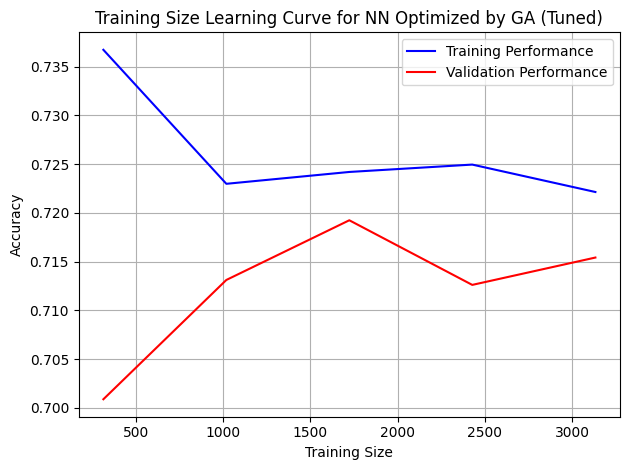

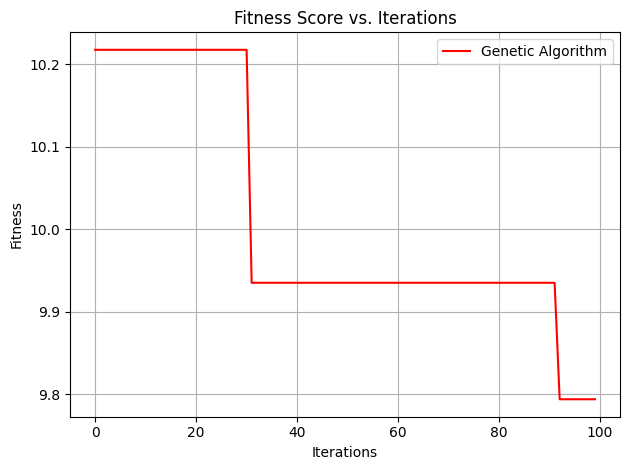

In [59]:
'''
Source: https://github.com/hiive/mlrose/blob/master/mlrose_hiive/neural/neural_network.py

'''

ga_mlp_clf = mlrose.NeuralNetwork(hidden_nodes=[25],
                                  activation='relu',
                                  algorithm='genetic_alg',
                                  max_iters=100,
                                  bias=True,
                                  is_classifier=True,
                                  learning_rate=0.1,
                                  early_stopping=False,
                                  pop_size=200,
                                  mutation_prob=0.4,
                                  max_attempts=10,
                                  random_state=37,
                                  curve=True)

# start timer for training
start = time.time()
# train classifier
ga_mlp_clf.fit(X_train, y_train)
# end timer for training
end = time.time()
# print total time for training
print(f"Total Training Time: {round(end-start, 5)}s")

# start timer for testing
start = time.time()
# make prediction
y_pred = ga_mlp_clf.predict(X_test)
# end timer for testing
end = time.time()
# print total time for testing
print(f"Total Testing Time: {round(end-start, 5)}s")

# evaluate model performance on test data
print("Accuracy using test set:", accuracy_score(y_test, y_pred))
# evaluate model performance using confusion_matrix
print(confusion_matrix(y_test, y_pred))
# evaluate model performance using classification_report
print(classification_report(y_test, y_pred))
# evaluate model performance using cross-validation
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)
cv_scores = cross_val_score(ga_mlp_clf, X, y, cv=skfold, scoring='accuracy')
print("Accuracy using cross-validation:", cv_scores.mean())

# plot learning curve using training and validation data
get_learning_curve_size(clf=ga_mlp_clf, clf_name="NN Optimized by GA (Tuned)", X=X_train, y=y_train)
# plot loss curve using using training data
# plot and show
fitness_curve = ga_mlp_clf.fitness_curve
plt.plot(fitness_curve[:,0], color="red", label="Genetic Algorithm")
plt.title("Fitness Score vs. Iterations")
plt.xlabel("Iterations"), plt.ylabel("Fitness"), plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.show()